
# ME 228 Course Project





## Group Members


*   Advait Sivakumar, 22B2185
*   Tanush Khairnar, 22B2184



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive



From Data of so many countries, making any sort of predictions on such a big
dataset would prove problematic. To make it simpler, we only consider some
countries of interest, particularly ones with the ‘cleanest’ data available. Cleanest
here refers to the least proportion of missing values, since Null values will have no
learning effect.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
power_data = pd.read_csv('/content/gdrive/MyDrive/ME 228/Course Project/data.csv')
power_data.head()

<ipython-input-4-078727d8c925>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  power_data = pd.read_csv('/content/gdrive/MyDrive/ME 228/Course Project/data.csv')


,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017
0,AFG,Afghanistan,Kajaki Hydroelectric Power Plant Afghanistan,GEODB0040538,33.0,32.322,65.1190,Hydro,NaN,NaN,...,123.77,162.90,97.39,137.76,119.50,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
1,AFG,Afghanistan,Kandahar DOG,WKS0070144,10.0,31.670,65.7950,Solar,NaN,NaN,...,18.43,17.48,18.25,17.70,18.29,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
2,AFG,Afghanistan,Kandahar JOL,WKS0071196,10.0,31.623,65.7920,Solar,NaN,NaN,...,18.64,17.58,19.10,17.62,18.72,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
3,AFG,Afghanistan,Mahipar Hydroelectric Power Plant Afghanistan,GEODB0040541,66.0,34.556,69.4787,Hydro,NaN,NaN,...,225.06,203.55,146.90,230.18,174.91,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
4,AFG,Afghanistan,Naghlu Dam Hydroelectric Power Plant Afghanistan,GEODB0040534,100.0,34.641,69.7170,Hydro,NaN,NaN,...,406.16,357.22,270.99,395.38,350.80,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1


In particular, we will choose India (IND)

In [5]:
ind_raw = power_data[power_data["country"] == "IND"]
usa_raw = power_data[power_data["country"] == "USA"]
bri_raw = power_data[power_data["country"] == "GBR"]
fra_raw = power_data[power_data["country"] == "FRA"]
braz_raw = power_data[power_data["country"] == "BRA"]

print(f"India Dataset Size : {ind_raw.shape}")
print(f"USA Dataset Size : {usa_raw.shape}")
print(f"Britain Dataset Size : {bri_raw.shape}")
print(f"France Dataset Size : {fra_raw.shape}")
print(f"Brazil Dataset Size : {braz_raw.shape}")

India Dataset Size : (1589, 36)
USA Dataset Size : (9833, 36)
Britain Dataset Size : (2751, 36)
France Dataset Size : (2155, 36)
Brazil Dataset Size : (2360, 36)


The Dataset we obtained from the website has a lot of columns, but most of them
are redundant and do not play any role in any sort of predictions. These ‘useless’
columns are the Names of the Owners, their Reference IDs, and Sources of
Informations. These will not be used in building any ML Model.

**Problem Statement** : For each of the power plants, longitude and latitude
locations are given. We would aim to find correlations between the locations of a
power plant and the type of Fuel they run on, i.e Coal, Oil or Hydro etc. Intuitively,
Coal Plants will be localised around a Coal source, and similar for the sources. The
objective would to be find these Clusters using the given data, and find these locations for each of the listed countries. For this, we will use a slightly modified K-
Means Clustering Algorithm, with a little hint of SVM Algorithms.

The reason not to directly use K-Means is that it will predict a larger area than actually possible if
there are less training samples, meaning that a location 100 km away from a Coal
Field will predicted as a potential Coal Plant, simply because there are no other
sources in the vicinity, while in reality having a plant there would not be feasible.
What we would do is apply K-Means, but points a certain distance away from any
Cluster Mean will not be classified into any of the classes, rather remain
unassigned.

Filtering only the important features

In [6]:
ind_data = ind_raw[["country", "capacity_mw", "latitude", "longitude", "primary_fuel"]]

In [14]:
all_lat = np.array(ind_data["latitude"])
all_lon = np.array(ind_data["longitude"])
all_fuel = np.array(ind_data["primary_fuel"])

test_size = len(all_lat) // 5  # 20% of the data
test_indices = np.random.choice(np.arange(len(all_lat)), size=test_size, replace=False)
test_lat = all_lat[test_indices]
test_lon = all_lon[test_indices]
test_fuel = all_fuel[test_indices]

# Original data (training data, excluding test data)
train_indices = np.delete(np.arange(len(all_lat)), test_indices)
lat = all_lat[train_indices]
lon = all_lon[train_indices]
fuel = all_fuel[train_indices]

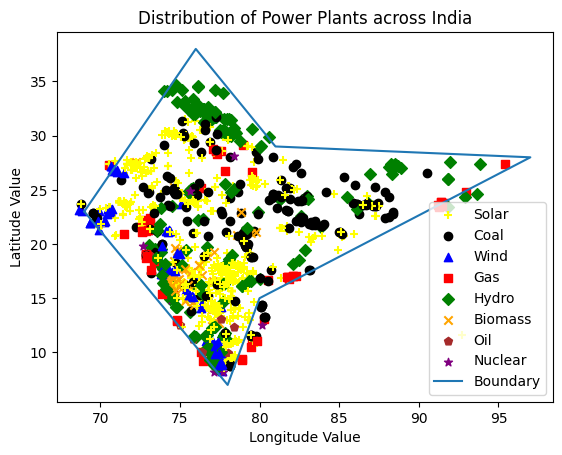

In [8]:
markers = {'Solar': '+', 'Coal': 'o', 'Wind': '^', 'Gas': 's', 'Hydro': 'D', 'Biomass': 'x', 'Oil': 'p', 'Nuclear': '*'}
colors = {'Solar': 'yellow', 'Coal': 'black', 'Wind': 'blue', 'Gas': 'red', 'Hydro': 'green', 'Biomass': 'orange', 'Oil': 'brown', 'Nuclear': 'purple'}

for i in range(len(fuel)):
  if fuel[i] != 0:
    plt.scatter(lon[i], lat[i], marker = markers[fuel[i]], color = colors[fuel[i]])

for i in ind_data["primary_fuel"].unique():
  for j in range(len(fuel)):
    if i == fuel[j]:
      plt.scatter(lon[j], lat[j], marker = markers[fuel[j]], color = colors[fuel[j]], label = f"{i}")
      break

plt.xlabel("Longitude Value")
plt.ylabel("Latitude Value")
plt.title("Distribution of Power Plants across India")

plt.plot([69, 78, 80, 97, 81, 76, 69], [23, 7, 15, 28, 29, 38, 23], label = "Boundary")

plt.legend()

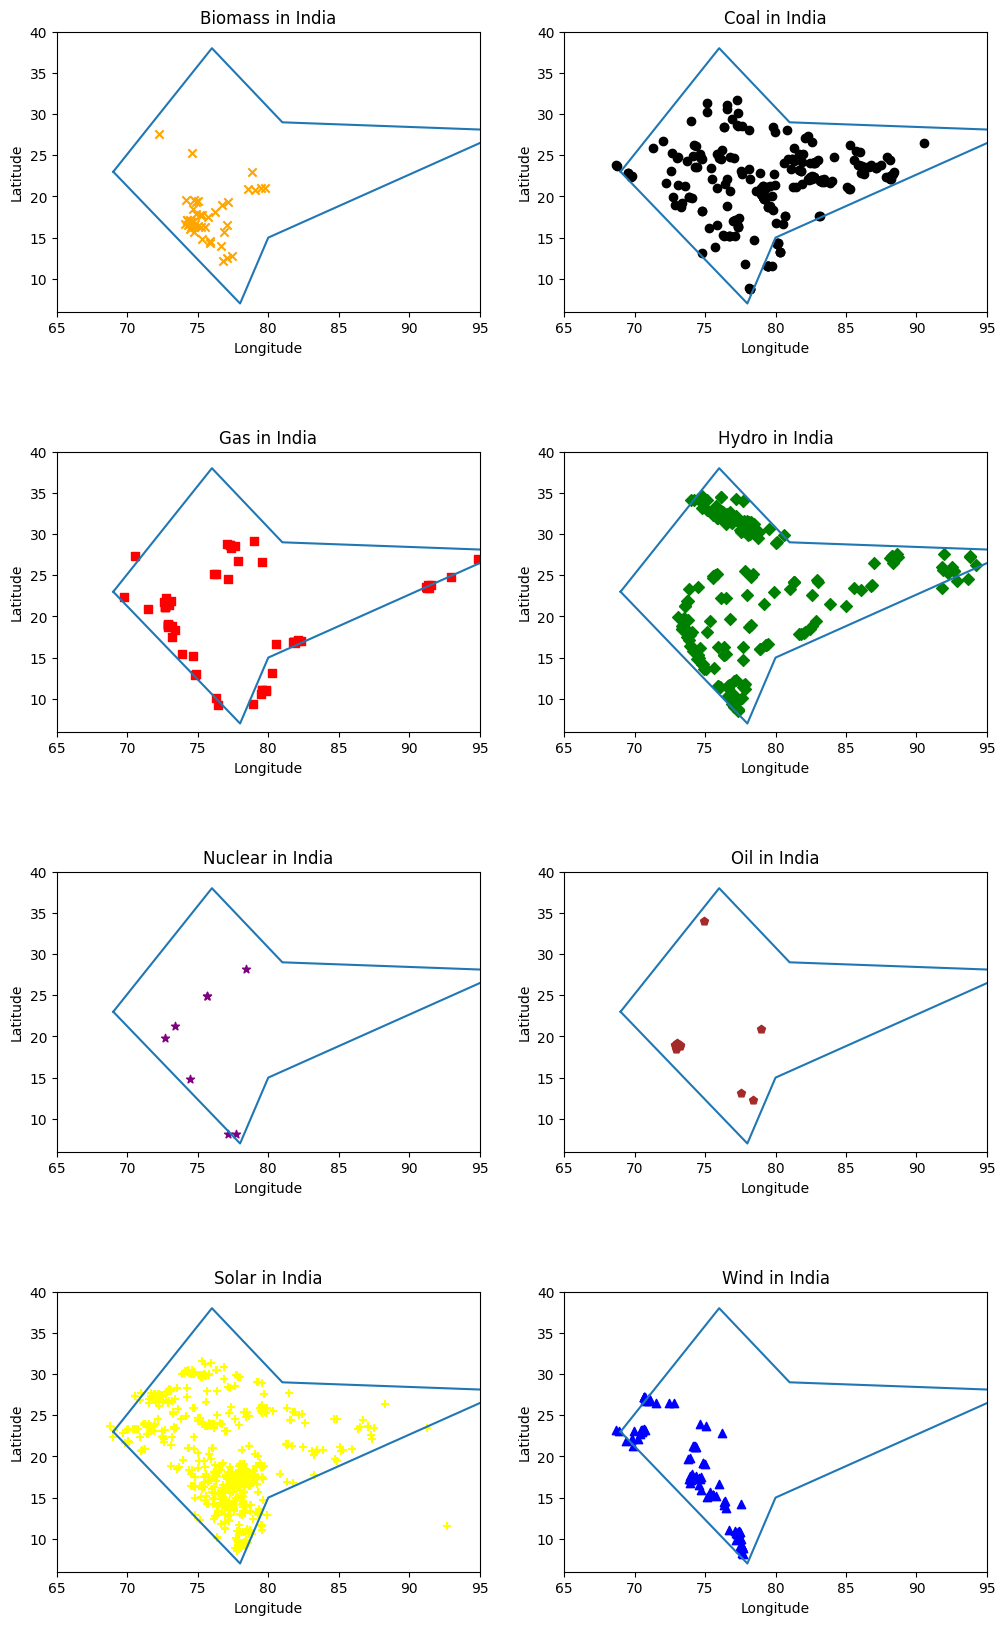

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

for i, (fuel_type, ax) in enumerate(zip(np.unique(fuel), axes.flatten())):
    # Filter data for the current fuel type
    fuel_lon = [lon[j] for j in range(len(lon)) if fuel[j] == fuel_type]
    fuel_lat = [lat[j] for j in range(len(lat)) if fuel[j] == fuel_type]

    # Plot data with markers and colors
    ax.scatter(fuel_lon, fuel_lat, marker=markers[fuel_type], color=colors[fuel_type])
    ax.set_ylim([6, 40])
    ax.set_xlim([65, 95])
    ax.plot([69, 78, 80, 97, 81, 76, 69], [23, 7, 15, 28, 29, 38, 23])
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"{fuel_type} in India")

plt.show()

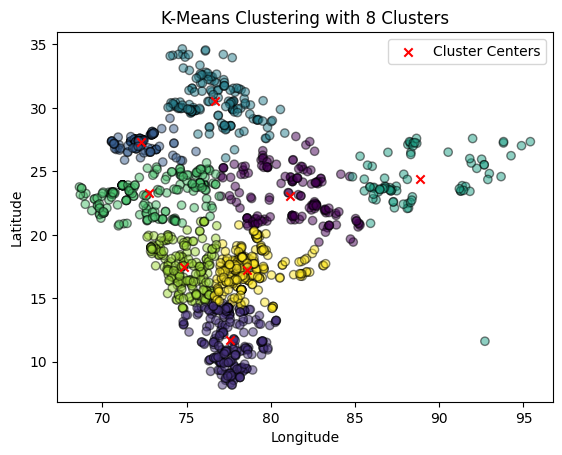

In [ ]:
from sklearn.cluster import KMeans

coordinates = np.column_stack((lat, lon))

k = 8
kmeans = KMeans(n_clusters=k, n_init = 10)

kmeans.fit(coordinates)
centers = kmeans.cluster_centers_

plt.scatter(lon, lat, c=kmeans.labels_, cmap='viridis', alpha=0.5, edgecolors='k')
plt.scatter(centers[:, 1], centers[:, 0], c='red', marker='x', label='Cluster Centers')

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering with 8 Clusters')

# Add legend
plt.legend()
plt.show()

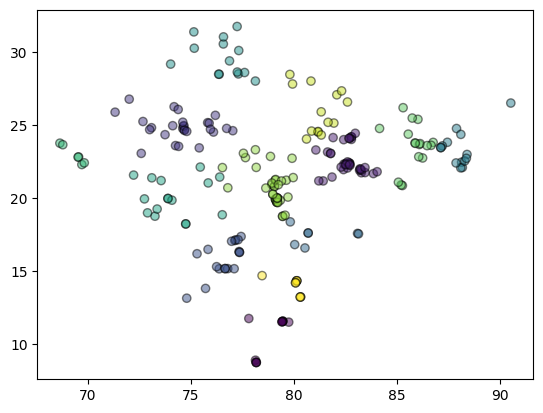

In [ ]:
coal_lat = []
coal_lon = []

for i in range(len(fuel)):
  if fuel[i] == "Coal":
    coal_lat.append(lat[i])
    coal_lon.append(lon[i])

coal_coord = np.column_stack((coal_lat, coal_lon))

coal_wcss = []

k = 1

while True:
  coal_kmeans = KMeans(n_clusters=k, n_init = 10)
  coal_kmeans.fit(coal_coord)
  a = coal_kmeans.inertia_
  coal_wcss.append(a)
  if a < 500:           # Threshold Within-Cluser-Sum of Squares is 500
    break               # For a tighter clustering
  k += 1

#plt.plot(coal_wcss)

plt.scatter(coal_lon, coal_lat, c=coal_kmeans.labels_, cmap='viridis', alpha=0.5, edgecolors='k')
plt.title("Attempt to Cluster coal data seperately")
plt.text(85, 15, "Threshold WCSS : 500")
plt.show()

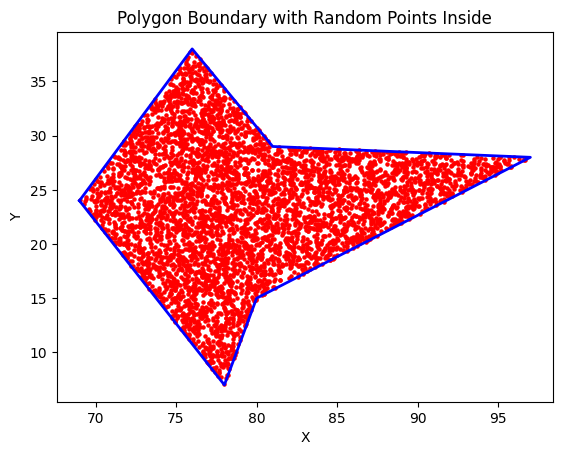

In [9]:
from shapely.geometry import Polygon, Point

# This code block will generate 5000 random points within the "boundaries"
# of India, which basically gives us a rough approximation model to play
# with the weights and thresholds

# Booundary Points : [69, 78, 80, 97, 81, 76, 69], [24, 7, 15, 28, 29, 38, 24]

polygon_coords = [(69, 24), (78, 7), (80, 15), (97, 28), (81, 29), (76, 38), (69, 24)]
polygon = Polygon(polygon_coords)
min_x, min_y, max_x, max_y = polygon.bounds

num_points = 5000
points = []
while len(points) < num_points:
    # Generate random point coordinates within the bounding box
    x = np.random.uniform(min_x, max_x)
    y = np.random.uniform(min_y, max_y)
    point = Point(x, y)
    # Check if the point falls inside the polygon
    if polygon.contains(point):
        points.append(point)

# Convert the list of points to a NumPy array for easier manipulation
points = np.array([(point.x, point.y) for point in points])

# Plot the polygon and the generated points
x, y = polygon.exterior.xy
plt.plot(x, y, color='blue', linewidth=2)
plt.scatter(points[:, 0], points[:, 1], color='red', s=5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Polygon Boundary with Random Points Inside')
plt.show()

x, y = points[:, 0], points[:, 1]

To proceed, we have defined a set of coordinates inside "India", and for each of these points, the likelihood of the points being any of the power sources will be calculated through a "weighted k-NNs" algorithm.

The system is weighted because in different power sources, the localising around a certain point differs.

For example,

*   Coal and Oil Power Plants will have higher weights, meaning the point of interest has to be very close to the actual plants to be classified as a potential Coal Plant.
*   Solar Plants can be a little more widespread, because the amount of sunshine every area receives is roughly equal, and highly seasonal.
*   Wind and Hydro Plants are also fairly localised, but not as much as Coal and Oil, but a little more than Solar
*   Biomass and Nuclear do not depend on the location of raw material, because biomass uses farming waste etc, whereas Nuclear uses very rare raadioactive fuels, which are not localised to any area.



75.24184695812085 18.870291806646925
Nearest points to the input point:


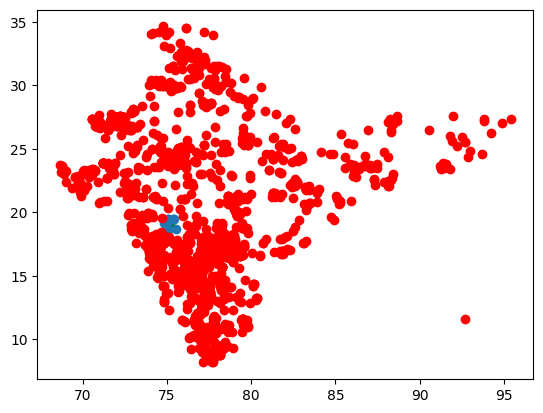

In [ ]:
# Now we try to find 10 nearest points to any specified point, to try and
# predict the distribution based on the trend in that particular neighbourhood

data = [[lat, lon] for lat, lon in zip(lat, lon)]

plt.scatter(x[0], y[0], color = "green")
print(x[0], y[0])

input_point = np.array([y[0], x[0]])

# Compute distances between the input point and all other points in the dataset
distances = np.linalg.norm(data - input_point, axis=1)

# Sort the points based on their distances from the input point
sorted_indices = np.argsort(distances)

# Select 10 nearest points to the input
nearest_indices = sorted_indices[:10]

nearest_x = []
nearest_y = []
for i in nearest_indices:
  nearest_x.append(lon[i])
  nearest_y.append(lat[i])

print("Nearest points to the input point:")
plt.scatter(nearest_x, nearest_y)

for i in range(len(lon)):
  if i not in nearest_indices:
    plt.scatter(lon[i], lat[i], color = "red")

KeyboardInterrupt: 

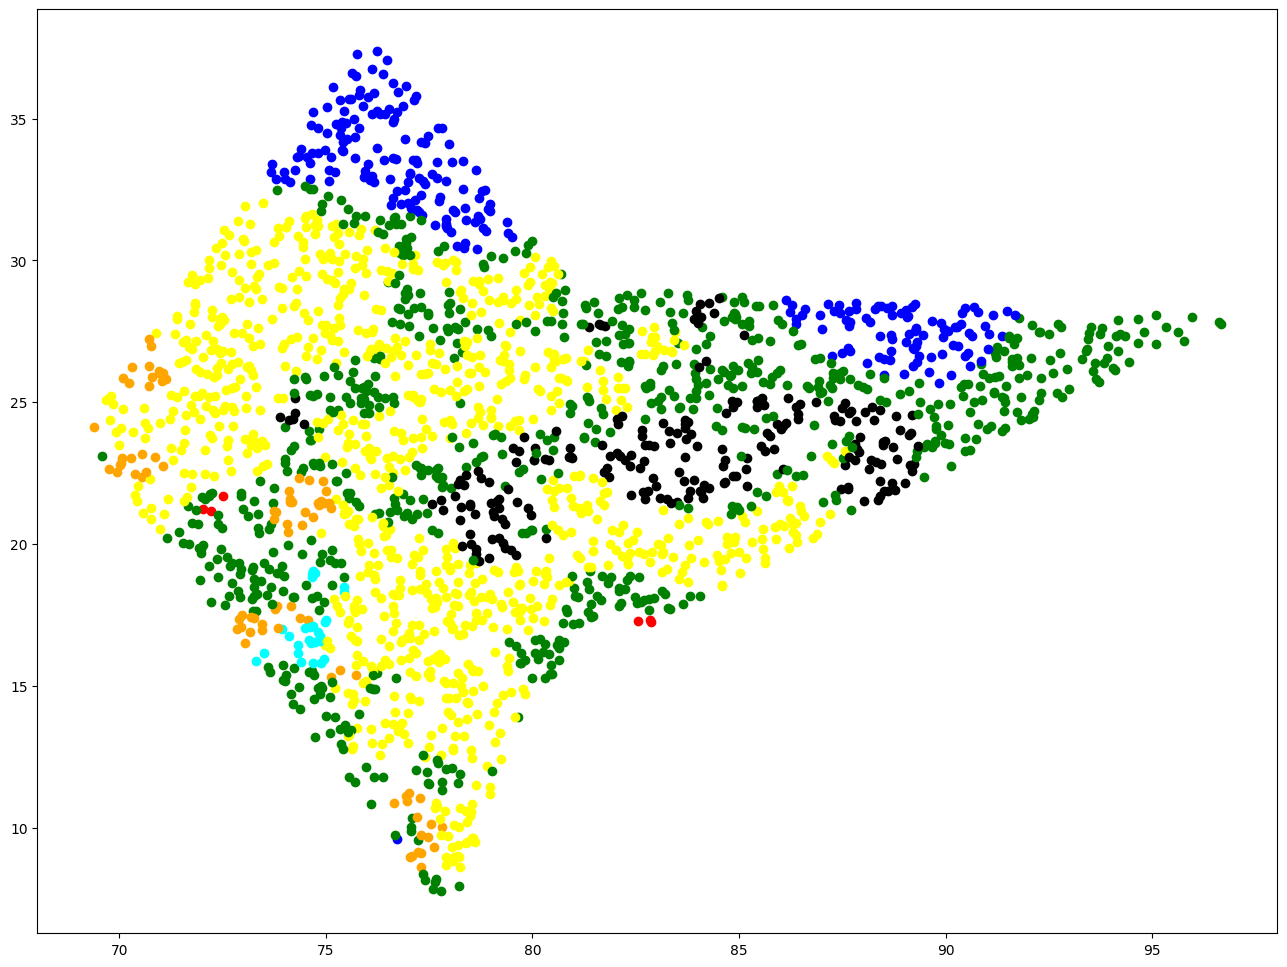

In [10]:
# Now, for the classification, each point is assigned a series of scores, and
# higher the score, the more probable a certain class

# For example, a score [6, 0, 0, 5, 0, 2, 1] indicates a higher chance of the
# point being classified as "Coal"

# But since the thresholds for classification are different, a higher score
# need not guarantee that prediction class

data = [[lat, lon] for lat, lon in zip(lat, lon)]

plt.figure(figsize=(16, 12))

for i in range(len(x)):
  test_point = np.array([y[i], x[i]])
  distances = np.linalg.norm(data - test_point, axis=1)

  sorted_indices = np.argsort(distances)
  nearest_indices = sorted_indices[:10]

  score = [0, 0, 0, 0, 0, 0, 0] # Coal, Oil, Solar, Biomass, Hydro, Gas, Wind

  # Adding scores based on Predictions

  for j in nearest_indices:
    if fuel[j] == "Coal":
      score[0] += 1
    elif fuel[j] == "Oil":
      score[1] += 1
    elif fuel[j] == "Solar":
      score[2] += 1
    elif fuel[j] == "Biomass":
      score[3] += 1
    elif fuel[j] == "Hydro":
      score[4] += 1
    elif fuel[j] == "Gas":
      score[5] += 1
    elif fuel[j] == "Wind":
      score[6] += 1

  first = [0, 0, 0, 0, 0, 0, 0, 0]

  # The thresholds are not completely fixed, have some freedom to obtain best
  # values for maximum accuracy

  if score[0] > 6:
    plt.scatter(x[i], y[i], color = "black", label = "Coal")
  elif score[1] > 7:
   plt.scatter(x[i], y[i], color = "brown", label = "Oil")
  elif score[2] > 4:
    plt.scatter(x[i], y[i], color = "yellow", label = "Solar")
  elif score[3] > 3:
    plt.scatter(x[i], y[i], color = "cyan", label = "Biomass")
  elif score[4] > 8:
    plt.scatter(x[i], y[i], color = "blue", label = "Hydro")
  elif score[5] > 6:
    plt.scatter(x[i], y[i], color = "red", label = "Gas")
  elif score[6] > 3:
    plt.scatter(x[i], y[i], color = "orange", label = "Wind")
  else:
    plt.scatter(x[i], y[i], color = "green", label = "Ambigous")

plt.text(85, 37, "Blue - Hydro ; Black - Coal; Yellow - Solar; Cyan - Biomass")
plt.text(85, 12, "Red - Gas; Orange - Wing; Brown - Oil; Green - Not Classified")

In [12]:
# Making the above algorithm into a function so that computation takes less time
# and predictions are easier to make

def find_label(test_lat, test_lon, data, original):

  labels = []

  for i in range(len(test_lat)):
    lon, lat = test_lon[i], test_lat[i]
    test_point = np.array(lon, lat)
    distances = np.linalg.norm(data - test_point, axis=1)

    sorted_indices = np.argsort(distances)
    nearest_indices = sorted_indices[:20]

    score = [0, 0, 0, 0, 0, 0, 0] # Coal, Oil, Solar, Biomass, Hydro, Gas, Wind

    for j in nearest_indices:
      if original[j] == "Coal":
        score[0] += 1
      elif original[j] == "Oil":
        score[1] += 1
      elif original[j] == "Solar":
        score[2] += 1
      elif original[j] == "Biomass":
        score[3] += 1
      elif original[j] == "Hydro":
        score[4] += 1
      elif original[j] == "Gas":
        score[5] += 1
      elif original[j] == "Wind":
        score[6] += 1

    # Based on the populations of data points, we can set threshold values
    # for classification of the points

    if score[3] > 1:
      labels.append("Biomass")
    elif score[6] >= 1 and score[2] < 10:
      labels.append("Wind")
    elif score[5] > 1:
      labels.append("Gas")
    elif score[2] > 15:
      labels.append("Solar")
    elif score[0] > 2:
      labels.append("Coal")
    elif score[1] > 1:
      labels.append("Oil")
    elif score[4] > 1:
      labels.append("Hydro")

    else:
      labels.append("Hydro")

  return labels


49 correct predictions out of 317
Accuracy :  15.46 %


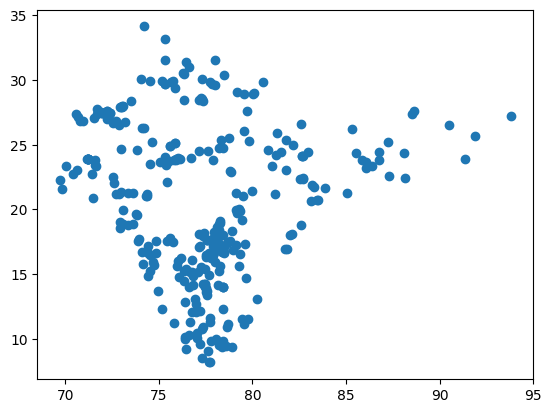

In [15]:
# Testing

# find_label(test_lat, test_lon, data, original)

score = 0

pred_fuel = find_label(test_lat, test_lon, data, all_fuel)

plt.scatter(test_lon, test_lat)

for i in range(len(pred_fuel)):
  if pred_fuel[i] == test_fuel[i]:
    score += 1

print(f"{score} correct predictions out of {len(test_lat)}")
print(f"Accuracy : {score / len(test_lat) * 100 : 0.2f} %")
